In [2]:
#####
###
### Input File in folder :  /data 
my_input_file="prostate.csv"
###
######
##############################Execution##########################
import findspark
findspark.init()

import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats

import subprocess
### subprocess.run('export SPARK_LOCAL_IP=0.0.0.0', shell=True)

sc = pyspark.SparkContext(appName="Prostate_Cancer_Predictor")
sqlContext = SQLContext(sc)

import h2o
from h2o.automl import H2OAutoML

# import subprocess
### subprocess.run('unset http_proxy', shell=True)
## TEST IP
my_ip="localhost" ## "<<MY HOSTNAME DOESN'T WORK>>" ##
h2o.init(ip=my_ip,port=54321)
#
#
#
internal_predict_files="file:///home/notebookuser/notebooks/data/"+my_input_file
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
### remove viewerID
internaldata_df1=sqlContext.read.csv(internal_predict_files,header='true').drop(col('ID'))\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
internaldata_df1.printSchema()
###
### >>> df1=internaldata_df1
### >>> df1.write.format("delta").save("file:///home/notebookuser/notebooks/data/delta_prostate/")
###
#
train_pd=internaldata_df1.toPandas() ##.head(10000) ## limit to 10,000 for demo purpose ## remove and wait 35min.
test_pd=internaldata_df1.toPandas().head(300)                                                                        
train=h2o.H2OFrame(train_pd)
test=h2o.H2OFrame(test_pd)
#
##
###### TRAINING PROCESS ############
# RBIND "Merge" all of 3 internal ccrawl and phishtank with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables
#
### train = train_hf1.rbind(train_hf2)
### test = test_hf1.rbind(test_hf2)
#
#
print("train")
print(train.head(10))
print("test")
print(test.head(10))
#
#
# Identify predictors and response
x = train.columns
#
# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'
#
# Classify and discovery for Average BitRate
#
y= 'VOL'
#
x.remove(y)
#
######## For binary classification, response should be a factor  #####
#####   train[y] = train[y].asfactor()
#####   test[y] = test[y].asfactor()
#
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
# Balance Classes to compensate unbalanced data
# Run AutoML for 12 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=25, max_runtime_secs=1860, seed=1999)#, exclude_algos=["DRF","GLM"])
aml.train(x=x, y=y, training_frame=train)
#
sc.stop()
#
print("Model Training Done!")
#

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 42 mins
H2O cluster timezone:,Etc/GMT
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,11 months and 21 days !!!
H2O cluster name:,H2O_from_python_notebookuser_duqo8i
H2O cluster total nodes:,1
H2O cluster free memory:,3.509 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,1
H2O cluster status:,"locked, healthy"


root
 |-- CAPSULE: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- RACE: string (nullable = true)
 |-- DPROS: string (nullable = true)
 |-- DCAPS: string (nullable = true)
 |-- PSA: string (nullable = true)
 |-- VOL: string (nullable = true)
 |-- GLEASON: string (nullable = true)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
train


CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
0,65,1,2,1,1.4,0,6
0,72,1,3,2,6.7,0,7
0,70,1,1,2,4.9,0,6
0,76,2,2,1,51.2,20,7
0,69,1,1,1,12.3,55.9,6
1,71,1,3,2,3.3,0,8
0,68,2,4,2,31.9,0,7
0,61,2,4,2,66.7,27.2,7
0,69,1,1,1,3.9,24,7
0,68,2,1,2,13,0,6



test


CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
0,65,1,2,1,1.4,0,6
0,72,1,3,2,6.7,0,7
0,70,1,1,2,4.9,0,6
0,76,2,2,1,51.2,20,7
0,69,1,1,1,12.3,55.9,6
1,71,1,3,2,3.3,0,8
0,68,2,4,2,31.9,0,7
0,61,2,4,2,66.7,27.2,7
0,69,1,1,1,3.9,24,7
0,68,2,1,2,13,0,6



AutoML progress: |████████████████████████████████████████████████████████| 100%
Model Training Done!


In [2]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
#
# The leader model is stored here
aml.leader
#

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20190802_090807


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 315.7143370129936
RMSE: 17.768352118668563
MAE: 14.428176528916639
RMSLE: 1.9186461679590505
Mean Residual Deviance: 315.7143370129936

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 380.76323976460475
RMSE: 19.51315555630623
MAE: 14.60411360126784
RMSLE: 1.8571965474479724
Mean Residual Deviance: 380.76323976460475

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 324.5847992515467
RMSE: 18.016237100225638
MAE: 14.63663119356101
RMSLE: 1.9339040955291211
Mean Residual Deviance: 324.5847992515467
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,14.636631,0.7436975,14.946516,14.738864,16.17156,14.4289,12.897316
mean_residual_deviance,324.5848,36.868732,321.37726,369.49716,345.5443,360.93912,225.56616
mse,324.5848,36.868732,321.37726,369.49716,345.5443,360.93912,225.56616
r2,0.0100719,0.0210445,0.0359208,0.0355588,-0.0439486,0.0211390,0.0016895
residual_deviance,324.5848,36.868732,321.37726,369.49716,345.5443,360.93912,225.56616
rmse,17.951077,1.0825019,17.926998,19.22231,18.588821,18.998398,15.01886
rmsle,1.9317158,0.0650343,2.0004594,1.7639532,1.95877,2.0229394,1.9124571


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-08-02 09:08:22,0.413 sec,0.0,18.2117578,14.6216751,331.6681237,19.2487386,14.5025000,370.5139390
,2019-08-02 09:08:22,0.423 sec,5.0,18.0531380,14.5512706,325.9157919,19.3260428,14.5018912,373.4959298
,2019-08-02 09:08:22,0.433 sec,10.0,17.9510774,14.5006915,322.2411796,19.3672653,14.5265237,375.0909659
,2019-08-02 09:08:22,0.444 sec,15.0,17.8876988,14.4757256,319.9697697,19.3899854,14.5603512,375.9715338
,2019-08-02 09:08:22,0.453 sec,20.0,17.8390295,14.4692723,318.2309735,19.4578471,14.5879906,378.6078136
,2019-08-02 09:08:22,0.463 sec,25.0,17.8029437,14.4423778,316.9448059,19.4976314,14.5866209,380.1576309
,2019-08-02 09:08:22,0.473 sec,30.0,17.7683521,14.4281765,315.7143370,19.5131556,14.6041136,380.7632398


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
AGE,13154.1123047,1.0,0.4687505
CAPSULE,8190.7060547,0.6226727,0.2918781
PSA,6717.2583008,0.5106584,0.2393714
RACE,0.0,0.0,0.0
DPROS,0.0,0.0,0.0
DCAPS,0.0,0.0,0.0
GLEASON,0.0,0.0,0.0


['StackedEnsemble_AllModels_AutoML_20190801_131833', 'StackedEnsemble_BestOfFamily_AutoML_20190801_131833', 'GBM_grid_1_AutoML_20190801_131833_model_4', 'GBM_1_AutoML_20190801_131833', 'DRF_1_AutoML_20190801_131833', 'GBM_grid_1_AutoML_20190801_131833_model_1', 'GBM_2_AutoML_20190801_131833', 'GBM_3_AutoML_20190801_131833', 'GBM_grid_1_AutoML_20190801_131833_model_6', 'GBM_4_AutoML_20190801_131833', 'GBM_grid_1_AutoML_20190801_131833_model_5', 'GBM_grid_1_AutoML_20190801_131833_model_3', 'GBM_grid_1_AutoML_20190801_131833_model_7', 'XRT_1_AutoML_20190801_131833', 'GBM_5_AutoML_20190801_131833', 'DeepLearning_1_AutoML_20190801_131833', 'GBM_grid_1_AutoML_20190801_131833_model_2', 'DeepLearning_grid_1_AutoML_20190801_131833_model_4', 'DeepLearning_grid_1_AutoML_20190801_131833_model_1', 'DeepLearning_grid_1_AutoML_20190801_131833_model_3', 'DeepLearning_grid_1_AutoML_20190801_131833_model_2', 'GLM_grid_1_AutoML_20190801_131833_model_1']
Model Details
H2OStackedEnsembleEstimator :  Stacke

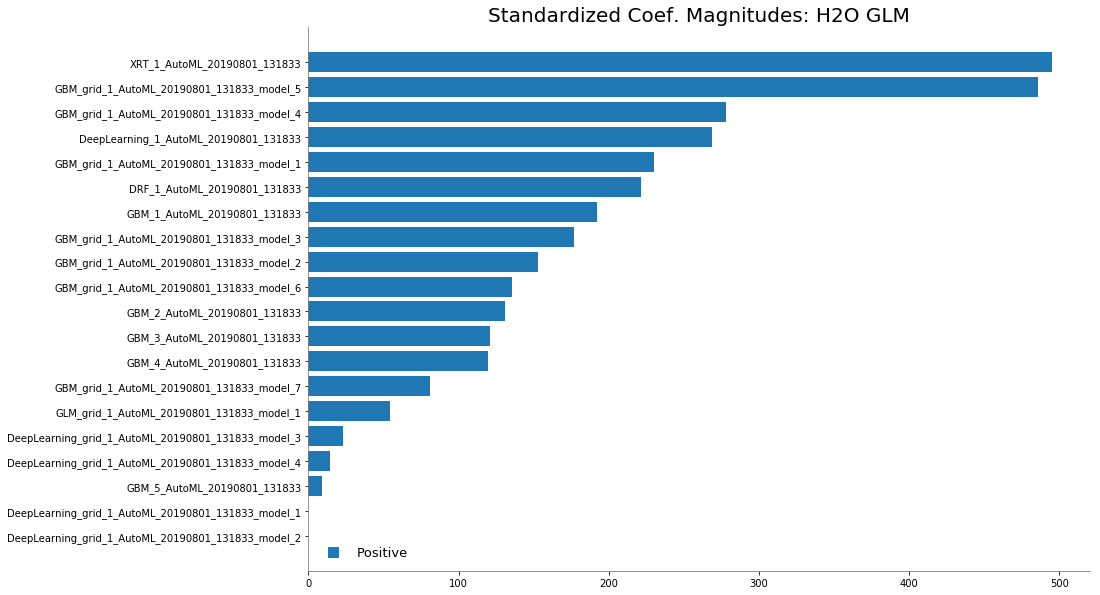

In [6]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
print(model_ids)
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
print(se)
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])
metalearner.coef_norm()
%matplotlib inline
metalearner.std_coef_plot()

In [4]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test")
print(test.head(100))
print("prediction")
print(preds.head(100))
#

gbm prediction progress: |████████████████████████████████████████████████| 100%
test


CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
0,65,1,2,1,1.4,0,6
0,72,1,3,2,6.7,0,7
0,70,1,1,2,4.9,0,6
0,76,2,2,1,51.2,20,7
0,69,1,1,1,12.3,55.9,6
1,71,1,3,2,3.3,0,8
0,68,2,4,2,31.9,0,7
0,61,2,4,2,66.7,27.2,7
0,69,1,1,1,3.9,24,7
0,68,2,1,2,13,0,6



prediction


predict
13.8712
17.9678
17.9678
20.6577
20.6577
15.0035
16.561
16.561
17.9678
16.561
